# 3. Models Training

This notebook trains three models:

1. **Random Forest** - Classical ML with statistical features
2. **Simple CNN** - Custom neural network from scratch
3. **Audio Spectrogram Transformer (AST)** - Fine-tuned pretrained model

In [1]:
# Imports
import sys
sys.path.insert(0, '..')

import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from src import config
from src.data_utils import load_manifest
from src.dataset import EDMDataset, RFDataset, create_dataloaders
from src.models import SimpleCNN, RandomForestModel, ASTModel, get_device
from src.training import Trainer, train_cnn, train_random_forest
from src.evaluation import evaluate_model, evaluate_random_forest, plot_learning_curves

# Create results directory
config.RESULTS_DIR.mkdir(parents=True, exist_ok=True)
config.MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Device
device = get_device()
print(f"Using device: {device}")

# Test for alghoritms
torch.backends.cudnn.benchmark = True

Using device: cuda


In [2]:
# Load manifest
manifest = load_manifest()
print(f"Total samples: {len(manifest)}")
print(f"\nSplit distribution:")
print(manifest['split'].value_counts())

Total samples: 2517

Split distribution:
split
train    1919
val       344
test      254
Name: count, dtype: int64


---
## Model 1: Random Forest (Classical ML)

Uses statistical features extracted from log-mel spectrograms.

In [14]:
%%time
# Load RF features (this may take a while)
print("Loading RF features...")
rf_train = RFDataset(manifest, split='train')
rf_val = RFDataset(manifest, split='val')
rf_test = RFDataset(manifest, split='test')

X_train, y_train = rf_train.get_data()
X_val, y_val = rf_val.get_data()
X_test, y_test = rf_test.get_data()

print(f"\nFeature shapes:")
print(f"  Train: {X_train.shape}")
print(f"  Val: {X_val.shape}")
print(f"  Test: {X_test.shape}")

Loading RF features...
RFDataset [train]: Loading 1919 samples...


100%|██████████| 1919/1919 [23:20<00:00,  1.37it/s]


Loaded 1919 samples with shape (1919, 1536)
RFDataset [val]: Loading 344 samples...


100%|██████████| 344/344 [04:20<00:00,  1.32it/s]


Loaded 344 samples with shape (344, 1536)
RFDataset [test]: Loading 254 samples...


100%|██████████| 254/254 [03:05<00:00,  1.37it/s]

Loaded 254 samples with shape (254, 1536)

Feature shapes:
  Train: (1919, 1536)
  Val: (344, 1536)
  Test: (254, 1536)
CPU times: total: 1h 12min 35s
Wall time: 30min 46s


In [15]:
%%time
# Train Random Forest
print("\n" + "="*60)
print("TRAINING RANDOM FOREST")
print("="*60)

rf_model = RandomForestModel(
    n_estimators=config.RF_N_ESTIMATORS,
    max_depth=config.RF_MAX_DEPTH,
    random_state=config.RANDOM_SEED
)

# Combine train and val for RF (no early stopping needed)
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.concatenate([y_train, y_val])

rf_model.fit(X_train_full, y_train_full)


TRAINING RANDOM FOREST
Training Random Forest on 2263 samples with 1536 features...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s


Training complete.
CPU times: total: 14.2 s
Wall time: 1.45 s


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.3s finished


In [16]:
# Save RF model
rf_model.save(str(config.MODELS_DIR / 'rf_model.pkl'))

Saved RF model to c:\Users\adria\Desktop\zum_project\notebooks\..\models\rf_model.pkl



Evaluating Random Forest on test set...

TEST RESULTS - Random Forest
Accuracy: 0.3110
Macro F1: 0.2471
Saved confusion matrix to c:\Users\adria\Desktop\zum_project\notebooks\..\results\confusion_matrix_rf.png


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.0s finished


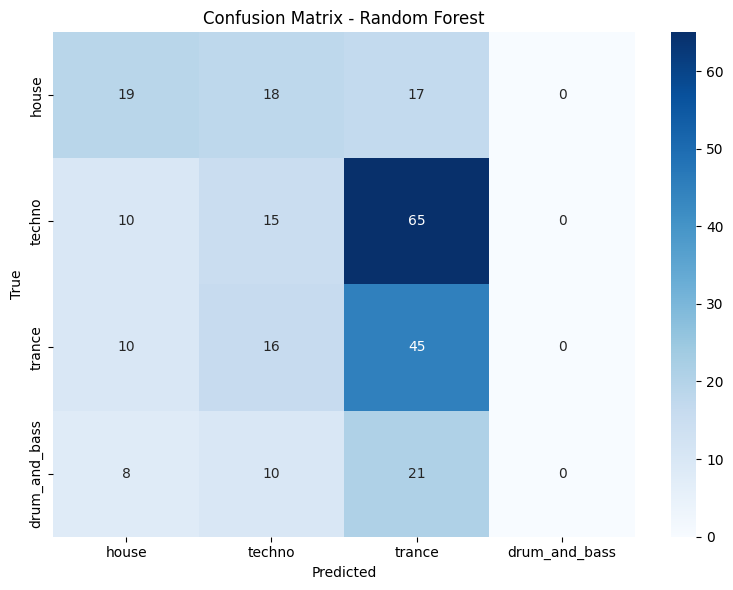

In [17]:
# Evaluate RF on test set
rf_metrics = evaluate_random_forest(rf_model, X_test, y_test, config.RESULTS_DIR)

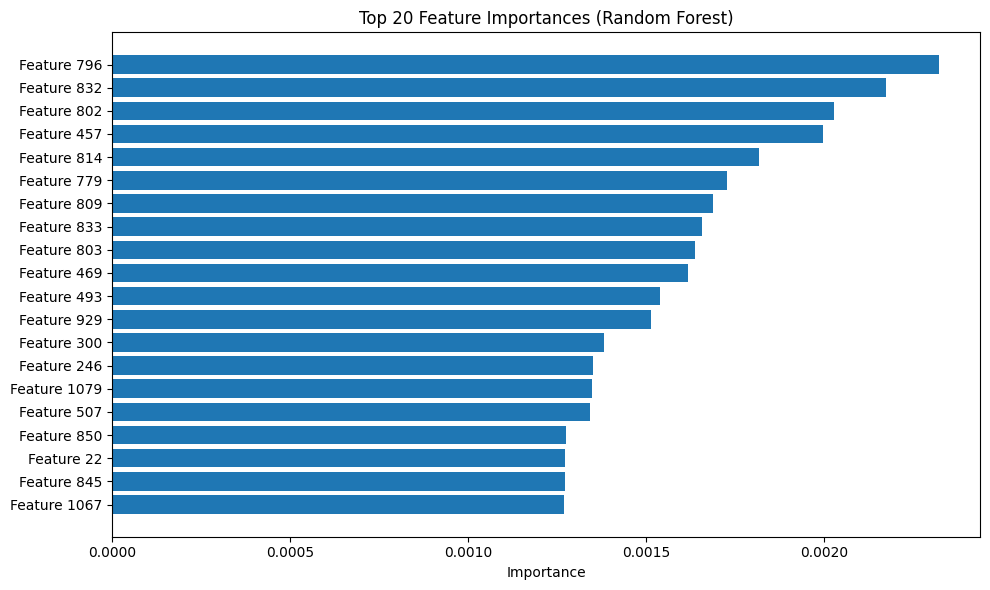

In [7]:
# Feature importance
importances = rf_model.model.feature_importances_
top_k = 20

indices = np.argsort(importances)[-top_k:]

plt.figure(figsize=(10, 6))
plt.barh(range(top_k), importances[indices])
plt.yticks(range(top_k), [f'Feature {i}' for i in indices])
plt.xlabel('Importance')
plt.title(f'Top {top_k} Feature Importances (Random Forest)')
plt.tight_layout()
plt.savefig(config.RESULTS_DIR / 'rf_feature_importance.png', dpi=150)
plt.show()

---
## Model 2: Simple CNN (Neural Network from scratch)

4-block convolutional neural network trained on log-mel spectrograms.

In [23]:
# Create dataloaders
train_loader, val_loader, test_loader = create_dataloaders(
    manifest,
    batch_size=config.CNN_BATCH_SIZE,
    augment=config.USE_SPECAUGMENT
)

print(f"Dataloader sizes:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

EDMDataset [train]: 1919 samples, augment=True
EDMDataset [val]: 344 samples, augment=False
EDMDataset [test]: 254 samples, augment=False
Dataloader sizes:
  Train batches: 60
  Val batches: 11
  Test batches: 8


In [24]:
# Create CNN model
cnn_model = SimpleCNN(num_classes=config.NUM_CLASSES)
print(f"\nModel architecture:")
print(cnn_model)
print(f"\nTotal parameters: {cnn_model.count_parameters():,}")


Model architecture:
SimpleCNN(
  (block1): ConvBlock(
    (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout): Dropout2d(p=0.1, inplace=False)
  )
  (block2): ConvBlock(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout): Dropout2d(p=0.2, inplace=False)
  )
  (block3): ConvBlock(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout): Dropout2d(p=0.3, i

In [25]:
%%time
# Train CNN
print("\n" + "="*60)
print("TRAINING SIMPLE CNN")
print("="*60)

cnn_output_dir = config.MODELS_DIR / 'cnn'
cnn_output_dir.mkdir(parents=True, exist_ok=True)

trainer = Trainer(
    model=cnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    output_dir=cnn_output_dir,
    learning_rate=config.CNN_LEARNING_RATE,
    weight_decay=config.CNN_WEIGHT_DECAY,
    epochs=config.CNN_EPOCHS,
    patience=config.CNN_EARLY_STOPPING_PATIENCE,
    device=device
)

cnn_history = trainer.train()


TRAINING SIMPLE CNN

Training on device: cuda
Model parameters: 98,148
Epochs: 30
------------------------------------------------------------

Epoch 1/30


Validating: 100%|██████████| 11/11 [00:48<00:00,  4.40s/it]


  Train Loss: 1.3843
  Val Loss: 1.3723 | Val Acc: 0.3110 | Val F1: 0.1792
  ✓ New best! Saving checkpoint...
Saved checkpoint to c:\Users\adria\Desktop\zum_project\notebooks\..\models\cnn\best_model.pt

Epoch 2/30


Validating: 100%|██████████| 11/11 [00:40<00:00,  3.70s/it]


  Train Loss: 1.3406
  Val Loss: 1.3383 | Val Acc: 0.2994 | Val F1: 0.1437
  No improvement (1/7)

Epoch 3/30


Validating: 100%|██████████| 11/11 [00:40<00:00,  3.70s/it]


  Train Loss: 1.3240
  Val Loss: 1.3508 | Val Acc: 0.2733 | Val F1: 0.1076
  No improvement (2/7)

Epoch 4/30


Validating: 100%|██████████| 11/11 [00:40<00:00,  3.71s/it]


  Train Loss: 1.3207
  Val Loss: 1.3027 | Val Acc: 0.3547 | Val F1: 0.2469
  ✓ New best! Saving checkpoint...
Saved checkpoint to c:\Users\adria\Desktop\zum_project\notebooks\..\models\cnn\best_model.pt

Epoch 5/30


Validating: 100%|██████████| 11/11 [00:40<00:00,  3.70s/it]


  Train Loss: 1.3102
  Val Loss: 1.3078 | Val Acc: 0.3663 | Val F1: 0.2628
  ✓ New best! Saving checkpoint...
Saved checkpoint to c:\Users\adria\Desktop\zum_project\notebooks\..\models\cnn\best_model.pt

Epoch 6/30


Validating: 100%|██████████| 11/11 [00:40<00:00,  3.67s/it]


  Train Loss: 1.3052
  Val Loss: 1.2960 | Val Acc: 0.3576 | Val F1: 0.2632
  No improvement (1/7)

Epoch 7/30


Validating: 100%|██████████| 11/11 [00:40<00:00,  3.70s/it]


  Train Loss: 1.3026
  Val Loss: 1.2911 | Val Acc: 0.3837 | Val F1: 0.2994
  ✓ New best! Saving checkpoint...
Saved checkpoint to c:\Users\adria\Desktop\zum_project\notebooks\..\models\cnn\best_model.pt

Epoch 8/30


Validating: 100%|██████████| 11/11 [00:40<00:00,  3.69s/it]


  Train Loss: 1.2931
  Val Loss: 1.3264 | Val Acc: 0.3256 | Val F1: 0.2067
  No improvement (1/7)

Epoch 9/30


Validating: 100%|██████████| 11/11 [00:40<00:00,  3.70s/it]


  Train Loss: 1.3011
  Val Loss: 1.3302 | Val Acc: 0.3227 | Val F1: 0.1992
  No improvement (2/7)

Epoch 10/30


Validating: 100%|██████████| 11/11 [00:40<00:00,  3.68s/it]


  Train Loss: 1.2874
  Val Loss: 1.3074 | Val Acc: 0.3605 | Val F1: 0.2449
  No improvement (3/7)

Epoch 11/30


Validating: 100%|██████████| 11/11 [00:40<00:00,  3.71s/it]


  Train Loss: 1.2979
  Val Loss: 1.2914 | Val Acc: 0.3750 | Val F1: 0.2836
  No improvement (4/7)

Epoch 12/30


Validating: 100%|██████████| 11/11 [00:40<00:00,  3.69s/it]


  Train Loss: 1.2917
  Val Loss: 1.2909 | Val Acc: 0.3547 | Val F1: 0.2642
  No improvement (5/7)

Epoch 13/30


Validating: 100%|██████████| 11/11 [00:40<00:00,  3.71s/it]


  Train Loss: 1.2874
  Val Loss: 1.3027 | Val Acc: 0.3314 | Val F1: 0.2179
  No improvement (6/7)

Epoch 14/30


Validating: 100%|██████████| 11/11 [00:40<00:00,  3.69s/it]

  Train Loss: 1.2789
  Val Loss: 1.2869 | Val Acc: 0.3605 | Val F1: 0.2746
  No improvement (7/7)

Early stopping triggered after 14 epochs

Training complete. Best Val F1: 0.2994
CPU times: total: 1min 16s
Wall time: 56min 35s


Saved learning curves to c:\Users\adria\Desktop\zum_project\notebooks\..\results\cnn_learning_curves.png


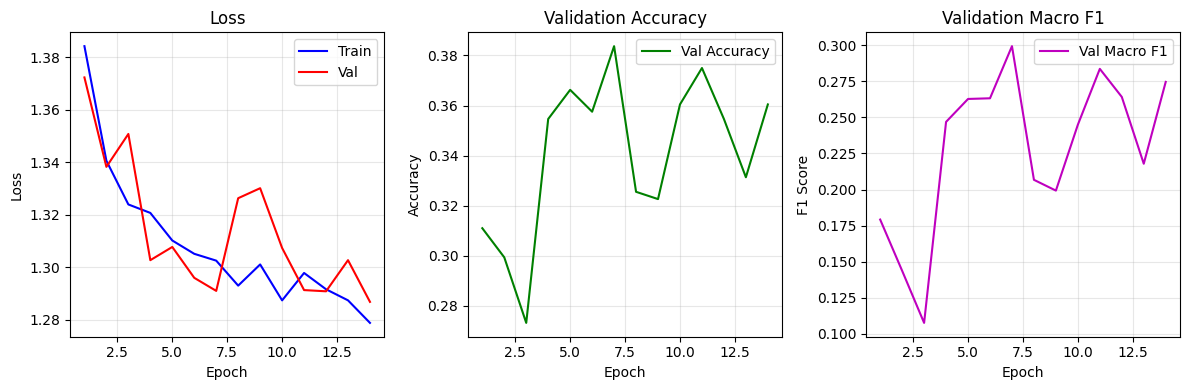

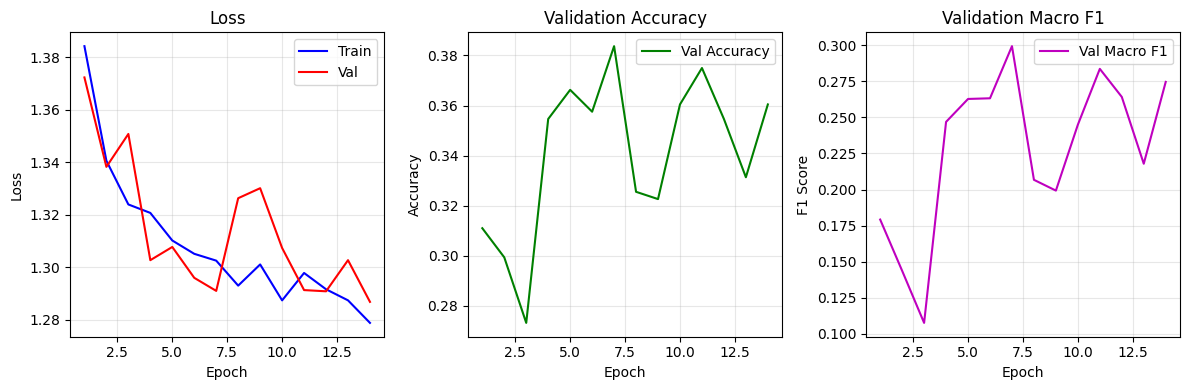

In [26]:
# Plot learning curves
plot_learning_curves(cnn_history, save_path=config.RESULTS_DIR / 'cnn_learning_curves.png')


Evaluating CNN on test set...


Testing: 100%|██████████| 8/8 [00:46<00:00,  5.81s/it]



TEST RESULTS - CNN
Accuracy: 0.3307
Macro F1: 0.2668
Macro Precision: 0.2573
Macro Recall: 0.3016

Per-class metrics:
  house:
    Precision: 0.3922
    Recall: 0.3704
    F1: 0.3810
  techno:
    Precision: 0.3284
    Recall: 0.2444
    F1: 0.2803
  trance:
    Precision: 0.3088
    Recall: 0.5915
    F1: 0.4058
  drum_and_bass:
    Precision: 0.0000
    Recall: 0.0000
    F1: 0.0000
Saved metrics to c:\Users\adria\Desktop\zum_project\notebooks\..\results\metrics_cnn.json
Saved confusion matrix to c:\Users\adria\Desktop\zum_project\notebooks\..\results\confusion_matrix_cnn.png


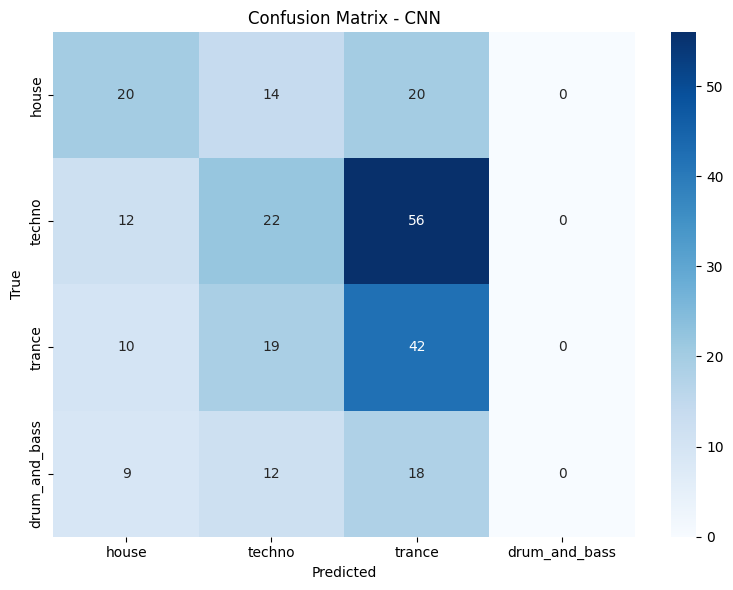

In [27]:
# Load best model and evaluate
checkpoint = torch.load(cnn_output_dir / 'best_model.pt', map_location=device, weights_only=False)

cnn_model.load_state_dict(checkpoint['model_state_dict'])

cnn_metrics = evaluate_model(
    cnn_model,
    test_loader,
    config.RESULTS_DIR,
    model_name='CNN',
    device=device
)

---
## Model 3: Audio Spectrogram Transformer (Fine-tuning)

Fine-tuning pretrained AST model from HuggingFace.


In [5]:
# Skip AST if not enough GPU memory
TRAIN_AST = True  # Set to False to skip AST training

if not torch.cuda.is_available():
    print("⚠️ WARNING: CUDA not available. AST training will be slow on CPU.")
    TRAIN_AST = input("Continue anyway? (y/n): ").lower() == 'y'

In [6]:
if TRAIN_AST:
    try:
        # Create AST model
        ast_model = ASTModel(
            model_name=config.AST_MODEL_NAME,
            num_classes=config.NUM_CLASSES,
            freeze_encoder=True,
            unfreeze_last_n=2
        )
        ast_model = ast_model.to(device)
        
        print(f"\nAST trainable parameters: {ast_model.count_parameters():,}")
    except Exception as e:
        print(f"Failed to load AST model: {e}")
        TRAIN_AST = False

Loading pretrained AST model: MIT/ast-finetuned-audioset-10-10-0.4593
AST model loaded. Trainable params: 14178820

AST trainable parameters: 14,178,820


In [7]:
%%time
if TRAIN_AST:
    from src.dataset import create_ast_dataloaders  # <-- DODAJ TO
    
    print("\n" + "="*60)
    print("TRAINING AUDIO SPECTROGRAM TRANSFORMER")
    print("="*60)
    ast_output_dir = config.MODELS_DIR / 'ast'
    ast_output_dir.mkdir(parents=True, exist_ok=True)
    # Use AST-specific dataloaders
    ast_train_loader, ast_val_loader, ast_test_loader = create_ast_dataloaders(
        manifest,
        batch_size=config.AST_BATCH_SIZE
    )
    ast_trainer = Trainer(
        model=ast_model,
        train_loader=ast_train_loader,
        val_loader=ast_val_loader,
        output_dir=ast_output_dir,
        learning_rate=config.AST_LEARNING_RATE,
        weight_decay=config.CNN_WEIGHT_DECAY,
        epochs=config.AST_EPOCHS,
        patience=3,
        device=device
    )
    ast_history = ast_trainer.train()


TRAINING AUDIO SPECTROGRAM TRANSFORMER
Loading ASTFeatureExtractor: MIT/ast-finetuned-audioset-10-10-0.4593
ASTDataset [train]: 1919 samples, target_sr=16000Hz
Loading ASTFeatureExtractor: MIT/ast-finetuned-audioset-10-10-0.4593
ASTDataset [val]: 344 samples, target_sr=16000Hz
Loading ASTFeatureExtractor: MIT/ast-finetuned-audioset-10-10-0.4593
ASTDataset [test]: 254 samples, target_sr=16000Hz

Training on device: cuda
Model parameters: 14,178,820
Epochs: 10
------------------------------------------------------------

Epoch 1/10


Validating: 100%|██████████| 22/22 [03:22<00:00,  9.20s/it]


  Train Loss: 1.2679
  Val Loss: 1.1899 | Val Acc: 0.4506 | Val F1: 0.4241
  ✓ New best! Saving checkpoint...
Saved checkpoint to c:\Users\adria\Desktop\zum_project\notebooks\..\models\ast\best_model.pt

Epoch 2/10


Validating: 100%|██████████| 22/22 [03:22<00:00,  9.18s/it]


  Train Loss: 1.0507
  Val Loss: 1.1642 | Val Acc: 0.4622 | Val F1: 0.4464
  ✓ New best! Saving checkpoint...
Saved checkpoint to c:\Users\adria\Desktop\zum_project\notebooks\..\models\ast\best_model.pt

Epoch 3/10


Validating: 100%|██████████| 22/22 [03:22<00:00,  9.20s/it]


  Train Loss: 0.9825
  Val Loss: 1.1772 | Val Acc: 0.4651 | Val F1: 0.4512
  ✓ New best! Saving checkpoint...
Saved checkpoint to c:\Users\adria\Desktop\zum_project\notebooks\..\models\ast\best_model.pt

Epoch 4/10


Validating: 100%|██████████| 22/22 [03:23<00:00,  9.25s/it]


  Train Loss: 0.9172
  Val Loss: 1.2062 | Val Acc: 0.4680 | Val F1: 0.4481
  No improvement (1/3)

Epoch 5/10


Validating: 100%|██████████| 22/22 [03:22<00:00,  9.18s/it]


  Train Loss: 0.8658
  Val Loss: 1.1655 | Val Acc: 0.4622 | Val F1: 0.4552
  ✓ New best! Saving checkpoint...
Saved checkpoint to c:\Users\adria\Desktop\zum_project\notebooks\..\models\ast\best_model.pt

Epoch 6/10


Validating: 100%|██████████| 22/22 [03:22<00:00,  9.21s/it]


  Train Loss: 0.8151
  Val Loss: 1.1471 | Val Acc: 0.4855 | Val F1: 0.4748
  ✓ New best! Saving checkpoint...
Saved checkpoint to c:\Users\adria\Desktop\zum_project\notebooks\..\models\ast\best_model.pt

Epoch 7/10


Validating: 100%|██████████| 22/22 [03:22<00:00,  9.18s/it]


  Train Loss: 0.7710
  Val Loss: 1.1662 | Val Acc: 0.4680 | Val F1: 0.4571
  No improvement (1/3)

Epoch 8/10


Validating: 100%|██████████| 22/22 [03:21<00:00,  9.14s/it]


  Train Loss: 0.7317
  Val Loss: 1.1591 | Val Acc: 0.4622 | Val F1: 0.4557
  No improvement (2/3)

Epoch 9/10


Validating: 100%|██████████| 22/22 [03:22<00:00,  9.21s/it]

  Train Loss: 0.7253
  Val Loss: 1.1717 | Val Acc: 0.4767 | Val F1: 0.4707
  No improvement (3/3)

Early stopping triggered after 9 epochs

Training complete. Best Val F1: 0.4748
CPU times: total: 8h 56min 4s
Wall time: 3h 18min 15s


Saved learning curves to c:\Users\adria\Desktop\zum_project\notebooks\..\results\ast_learning_curves.png

Evaluating AST on test set...


Testing: 100%|██████████| 16/16 [02:39<00:00,  9.97s/it]



TEST RESULTS - AST
Accuracy: 0.5276
Macro F1: 0.5563
Macro Precision: 0.5772
Macro Recall: 0.5427

Per-class metrics:
  house:
    Precision: 0.5208
    Recall: 0.4630
    F1: 0.4902
  techno:
    Precision: 0.4674
    Recall: 0.4778
    F1: 0.4725
  trance:
    Precision: 0.4819
    Recall: 0.5634
    F1: 0.5195
  drum_and_bass:
    Precision: 0.8387
    Recall: 0.6667
    F1: 0.7429
Saved metrics to c:\Users\adria\Desktop\zum_project\notebooks\..\results\metrics_ast.json
Saved confusion matrix to c:\Users\adria\Desktop\zum_project\notebooks\..\results\confusion_matrix_ast.png


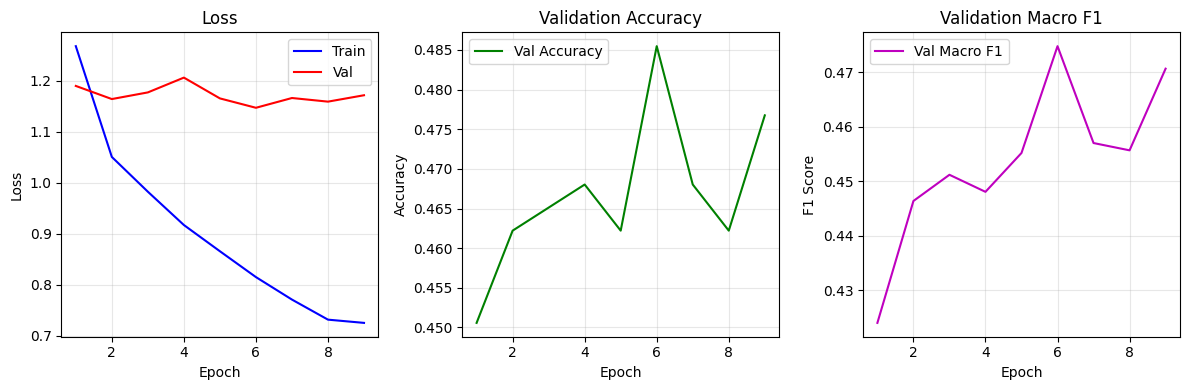

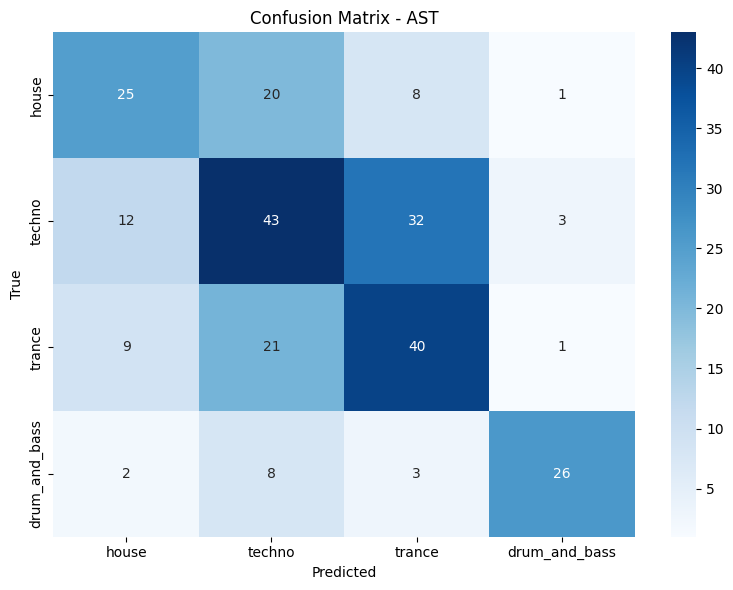

In [28]:
if TRAIN_AST:
    # Plot AST learning curves
    plot_learning_curves(ast_history, save_path=config.RESULTS_DIR / 'ast_learning_curves.png')
    
    # Evaluate AST
    checkpoint = torch.load(ast_output_dir / 'best_model.pt', map_location=device, weights_only=False)
    ast_model.load_state_dict(checkpoint['model_state_dict'])
    
    ast_metrics = evaluate_model(
        ast_model,
        ast_test_loader,
        config.RESULTS_DIR,
        model_name='AST',
        device=device
    )
else:
    ast_metrics = None
    print("AST training skipped.")

---
## Summary

In [29]:
# Summary of all models
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)

print("\n1. Random Forest:")
print(f"   Accuracy: {rf_metrics['accuracy']:.4f}")
print(f"   Macro F1: {rf_metrics['macro_f1']:.4f}")

print("\n2. Simple CNN:")
print(f"   Accuracy: {cnn_metrics['accuracy']:.4f}")
print(f"   Macro F1: {cnn_metrics['macro_f1']:.4f}")

if ast_metrics:
    print("\n3. Audio Spectrogram Transformer:")
    print(f"   Accuracy: {ast_metrics['accuracy']:.4f}")
    print(f"   Macro F1: {ast_metrics['macro_f1']:.4f}")
else:
    print("\n3. AST: Not trained")

print("\n" + "="*60)


TRAINING SUMMARY

1. Random Forest:
   Accuracy: 0.3110
   Macro F1: 0.2471

2. Simple CNN:
   Accuracy: 0.3307
   Macro F1: 0.2668

3. Audio Spectrogram Transformer:
   Accuracy: 0.5276
   Macro F1: 0.5563



In [30]:
# Save results for later comparison
import json

all_results = {
    'Random Forest': {
        'accuracy': rf_metrics['accuracy'],
        'macro_f1': rf_metrics['macro_f1'],
        'macro_precision': rf_metrics['macro_precision'],
        'macro_recall': rf_metrics['macro_recall']
    },
    'CNN': {
        'accuracy': cnn_metrics['accuracy'],
        'macro_f1': cnn_metrics['macro_f1'],
        'macro_precision': cnn_metrics['macro_precision'],
        'macro_recall': cnn_metrics['macro_recall']
    }
}

if ast_metrics:
    all_results['AST'] = {
        'accuracy': ast_metrics['accuracy'],
        'macro_f1': ast_metrics['macro_f1'],
        'macro_precision': ast_metrics['macro_precision'],
        'macro_recall': ast_metrics['macro_recall']
    }

with open(config.RESULTS_DIR / 'all_results.json', 'w') as f:
    json.dump(all_results, f, indent=2)

print(f"Results saved to {config.RESULTS_DIR / 'all_results.json'}")

Results saved to c:\Users\adria\Desktop\zum_project\notebooks\..\results\all_results.json
